In [1]:
import math
import torch

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Simple one-dimensional heteroskedastic example (similar to Forrester et al. (2008)):
- function: $f(x) = 20 - (6x − 2)^2 \sin(12x − 4)$
- noise function: $r(x) = 1.1 + \sin(2\pi x)$.

In [2]:
def f(x):
    return 20 - (6 * x - 2)**2 * torch.sin(12 * x - 4)

def r(x):
    return 0.5 + 2 * torch.sin(2 * math.pi * x)**2

In [3]:
train_x = torch.linspace(0, 1, 35)
train_y_sem = r(train_x)
train_y = f(train_x) + train_y_sem * torch.randn_like(train_x)

# let's assume all points were sampled with the normalized fidelity of 1
train_phi = torch.ones_like(train_x)

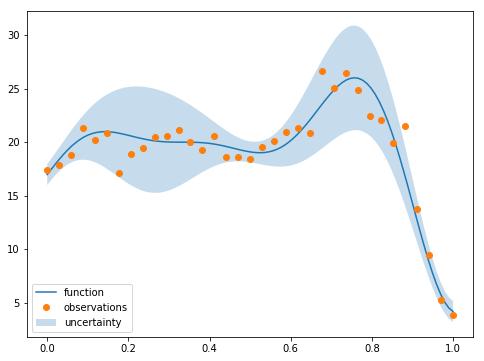

In [4]:
plot_x = torch.linspace(0, 1, 100)
plot_f = f(plot_x)
plot_f_lower = plot_f - 1.96 * r(plot_x)
plot_f_upper = plot_f + 1.96 * r(plot_x)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(plot_x.numpy(), plot_f.numpy(), label="function")
ax.fill_between(plot_x.numpy(), plot_f_lower.numpy(), plot_f_upper.numpy(), alpha=0.25, label="uncertainty")
ax.plot(train_x.numpy(), train_y.numpy(), 'o', label="observations")
ax.legend(loc="lower left")

# Fit and evaluate the model

In [5]:
import gpytorch

from botorch.models import FidelityAwareSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_model

In [6]:
# augment our original training data with the fidelity parameter
train_X = torch.stack([train_x, train_phi], -1)

In [7]:
model = FidelityAwareSingleTaskGP(train_X, train_y, train_y_sem)
mll = ExactMarginalLogLikelihood(model.likelihood, model)

In [8]:
mll = fit_model(mll)

In [9]:
test_x = torch.linspace(0, 1, 75)
test_phi = 0.25 + 5 * test_x
test_X = torch.stack([test_x, test_phi], -1)

with torch.no_grad(), gpytorch.fast_pred_var():   
    post_f = model(test_X)
    post_obs = model.likelihood(post_f, test_X)
    lower_f, upper_f = post_f.confidence_region()
    lower_obs, upper_obs = post_obs.confidence_region()

/mnt/c/Users/Gardn/linux/gpytorch/gpytorch/models/exact_gp.py:177: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


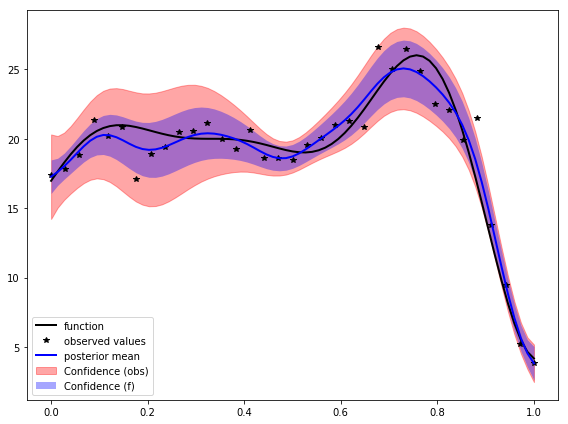

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(test_x.numpy(), f(test_x).numpy(), 'k', linewidth=2, label="function")
ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label="observed values")
ax.plot(test_x.numpy(), post_f.mean.numpy(), 'b', linewidth=2, label="posterior mean")
ax.fill_between(test_x.numpy(), lower_obs.numpy(), upper_obs.numpy(), color='r', alpha=0.35, label="Confidence (obs)")
ax.fill_between(test_x.numpy(), lower_f.numpy(), upper_f.numpy(), color='b', alpha=0.35, linewidth=0, label="Confidence (f)")
ax.legend(loc="lower left")
plt.tight_layout()

# check qKG

In [11]:
from botorch.acquisition import qKnowledgeGradient

In [12]:
qKG = qKnowledgeGradient(
    model=model,
    X_observed=train_X,
    mc_samples=10,
    inner_mc_samples=1000,
)

In [13]:
test_X = torch.tensor([[0.7568, 4.0338], [0.75, 4.03]], requires_grad=True)

In [14]:
from copy import deepcopy
new_model = deepcopy(model)  # This works

fantasy_model = model.get_fantasy_model(test_X, torch.randn(2))
new_model = deepcopy(model)  # Still works

In [15]:
out = qKG(test_X)
out

/mnt/c/Users/Gardn/linux/gpytorch/gpytorch/kernels/kernel.py:277: UserWarning: You are using a version of PyTorch where torch.pdist does not support batch matrices. Falling back on manual distance computation. Updating PyTorch to the latest pytorch-nightly build will offer significant memory savings during kernel computation.
  warnings.warn('You are using a version of PyTorch where torch.pdist does not support batch '


tensor([-0.5079], grad_fn=<CatBackward>)

In [16]:
new_model = deepcopy(model)  # Broken

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment